In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Libraries loaded")

Libraries loaded


In [2]:
# Load data
df = pd.read_csv('Wisconsin.csv')
y = df['target'].values
X = df.drop('target', axis=1).values
feature_names = df.drop('target', axis=1).columns.tolist()

print(f"Data loaded. Features: {len(feature_names)}")

Data loaded. Features: 30


In [3]:
# Standardize
def standardize(X):
    mean_vals = np.mean(X, axis=0)
    std_vals = np.std(X, axis=0)
    std_vals[std_vals == 0] = 1
    X_std = (X - mean_vals) / std_vals
    return X_std, mean_vals, std_vals

X_scaled, X_mean, X_std = standardize(X)

In [4]:
# Split data
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    m = X.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)
    split_idx = int((1 - test_size) * m)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
# Functions from Part B
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def hypothesis(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)

def compute_cost(X, y, w, b):
    m = X.shape[0]
    h = hypothesis(X, w, b)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    cost = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

def compute_gradients(X, y, w, b):
    m = X.shape[0]
    h = hypothesis(X, w, b)
    error = h - y
    dw = np.dot(X.T, error) / m
    db = np.mean(error)
    return dw, db

def gradient_descent(X, y, iterations=3000, learning_rate=0.1):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    costs = []
    for i in range(iterations):
        dw, db = compute_gradients(X, y, w, b)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        cost = compute_cost(X, y, w, b)
        costs.append(cost)
    return w, b, costs

print("All functions loaded")

All functions loaded


In [6]:
# Train model
print("Training model...")
w_final, b_final, cost_history = gradient_descent(X_train, y_train, iterations=3000, learning_rate=0.1)
print("Model trained")
print(f"Final cost: {cost_history[-1]:.6f}")

Training model...
Model trained
Final cost: 0.044464


---
# Part D1: Parameter Analysis and Feature Relevance (1 Mark)

Examine the learned coefficients to identify which tumor characteristics contribute most to predictions

**Interpretation Guide:**
- Larger magnitude coefficients = stronger prediction influence
- Positive coefficients = increase likelihood of malignancy class
- Negative coefficients = increase likelihood of benignity class

In [7]:
# Analyze weights
print(f"Number of features: {len(w_final)}")
print(f"Bias term: {b_final:.6f}")

# Create a dataframe with weights and feature names
weight_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': w_final,
    'Abs_Weight': np.abs(w_final)
})

# Sort by absolute weight
weight_df = weight_df.sort_values('Abs_Weight', ascending=False)

print("\nTop 10 Most Important Features:")
print(weight_df.head(10).to_string(index=False))

Number of features: 30
Bias term: -0.346364

Top 10 Most Important Features:
             Feature    Weight  Abs_Weight
        radius error  1.465975    1.465975
       worst texture  1.288964    1.288964
        worst radius  1.165958    1.165958
          worst area  1.142702    1.142702
          area error  1.103092    1.103092
   compactness error -1.080756    1.080756
     worst perimeter  1.016108    1.016108
worst concave points  0.991774    0.991774
     perimeter error  0.939517    0.939517
     worst concavity  0.907667    0.907667


In [8]:
# Identify features that push toward malignant (positive weights)
positive_weights = weight_df[weight_df['Weight'] > 0].sort_values('Weight', ascending=False)
negative_weights = weight_df[weight_df['Weight'] < 0].sort_values('Weight', ascending=True)

print("\n" + "="*60)
print("FEATURES PUSHING TOWARD MALIGNANT (Positive Weights)")
print("="*60)
print(positive_weights[['Feature', 'Weight']].head(10).to_string(index=False))

print("\n" + "="*60)
print("FEATURES PUSHING TOWARD BENIGN (Negative Weights)")
print("="*60)
print(negative_weights[['Feature', 'Weight']].head(10).to_string(index=False))


FEATURES PUSHING TOWARD MALIGNANT (Positive Weights)
             Feature   Weight
        radius error 1.465975
       worst texture 1.288964
        worst radius 1.165958
          worst area 1.142702
          area error 1.103092
     worst perimeter 1.016108
worst concave points 0.991774
     perimeter error 0.939517
     worst concavity 0.907667
      worst symmetry 0.893493

FEATURES PUSHING TOWARD BENIGN (Negative Weights)
                Feature    Weight
      compactness error -1.080756
fractal dimension error -0.541694
         symmetry error -0.432122
 mean fractal dimension -0.347045
       mean compactness -0.261277
          mean symmetry -0.132685
        concavity error -0.100518
          texture error -0.072807


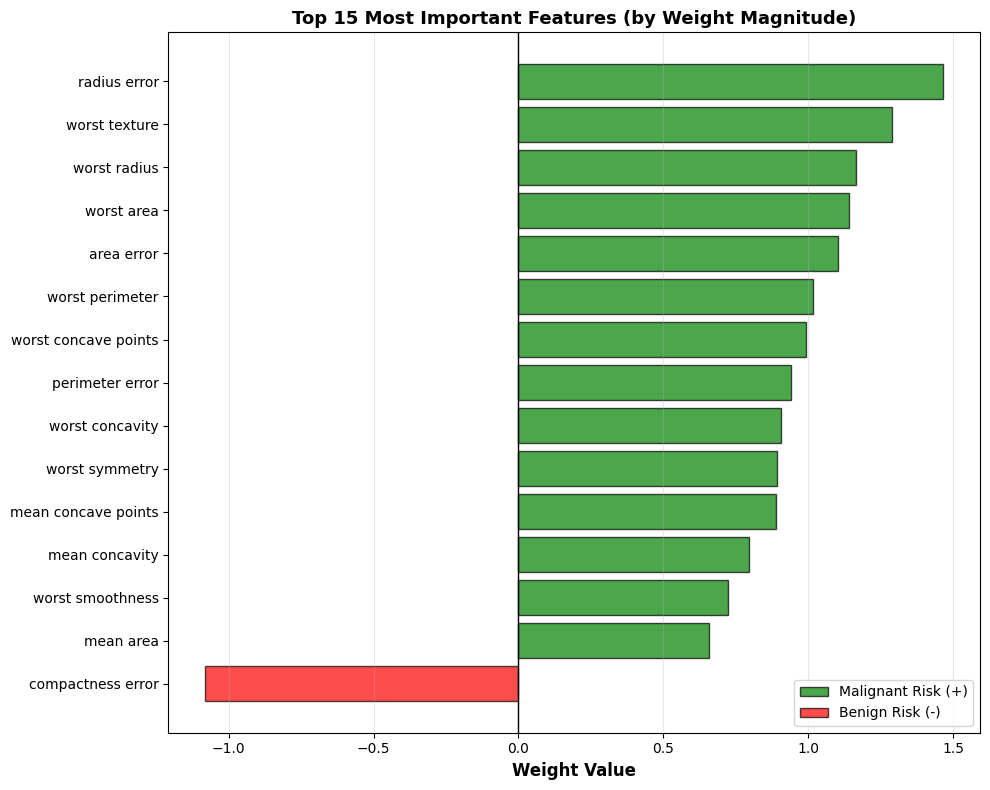

Feature importance visualization complete


In [9]:
# Visualize top 15 features by importance
top_15 = weight_df.head(15).copy()
top_15 = top_15.sort_values('Weight')

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red' if x < 0 else 'green' for x in top_15['Weight']]
ax.barh(top_15['Feature'], top_15['Weight'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Weight Value', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Important Features (by Weight Magnitude)', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, edgecolor='black', label='Malignant Risk (+)'),
                   Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Benign Risk (-)')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("Feature importance visualization complete")

In [10]:
# Analyze feature groups
print("\n" + "="*60)
print("FEATURE ANALYSIS BY TYPE")
print("="*60)

# Group features by type
mean_features = [f for f in feature_names if f.startswith('mean')]
error_features = [f for f in feature_names if 'error' in f]
worst_features = [f for f in feature_names if f.startswith('worst')]

print(f"\nMean features: {len(mean_features)}")
mean_weights = [w_final[feature_names.index(f)] for f in mean_features]
print(f"  Average importance: {np.mean(np.abs(mean_weights)):.6f}")
print(f"  Max importance: {np.max(np.abs(mean_weights)):.6f}")

print(f"\nError features: {len(error_features)}")
error_weights = [w_final[feature_names.index(f)] for f in error_features]
print(f"  Average importance: {np.mean(np.abs(error_weights)):.6f}")
print(f"  Max importance: {np.max(np.abs(error_weights)):.6f}")

print(f"\nWorst features: {len(worst_features)}")
worst_weights = [w_final[feature_names.index(f)] for f in worst_features]
print(f"  Average importance: {np.mean(np.abs(worst_weights)):.6f}")
print(f"  Max importance: {np.max(np.abs(worst_weights)):.6f}")


FEATURE ANALYSIS BY TYPE

Mean features: 10
  Average importance: 0.538077
  Max importance: 0.890109

Error features: 10
  Average importance: 0.625857
  Max importance: 1.465975

Worst features: 10
  Average importance: 0.867457
  Max importance: 1.288964


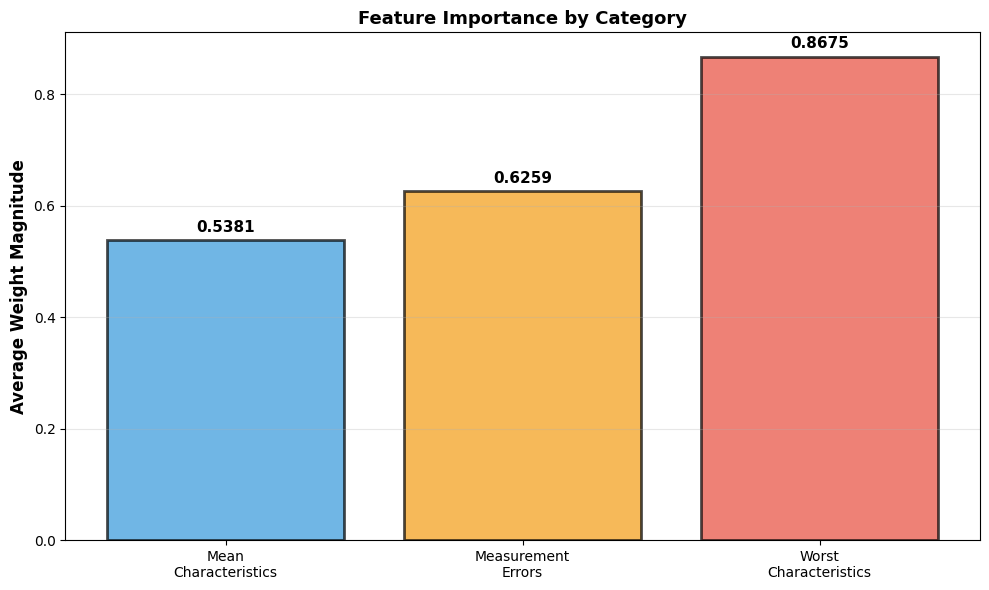

Feature group analysis plotted


In [11]:
# Visualize feature importance by group
fig, ax = plt.subplots(figsize=(10, 6))

groups = ['Mean\nCharacteristics', 'Measurement\nErrors', 'Worst\nCharacteristics']
importances = [
    np.mean(np.abs(mean_weights)),
    np.mean(np.abs(error_weights)),
    np.mean(np.abs(worst_weights))
]

colors_group = ['#3498db', '#f39c12', '#e74c3c']
ax.bar(groups, importances, color=colors_group, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Weight Magnitude', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance by Category', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (group, importance) in enumerate(zip(groups, importances)):
    ax.text(i, importance + 0.01, f'{importance:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("Feature group analysis plotted")

---
# Part D2: Explicability and Actionability (2 Marks)

Communicate model behavior and output interpretation in non-technical language

In [12]:
# Make predictions on test set
y_pred_prob = hypothesis(X_test, w_final, b_final)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Sample Predictions on Test Set")
print("="*80)
print(f"{'Actual':<10} {'Predicted':<12} {'Probability':<15} {'Confidence':<15} {'Diagnosis'}")
print("-"*80)

for i in range(10):
    actual = y_test[i]
    pred = y_pred[i]
    prob = y_pred_prob[i]
    confidence = max(prob, 1-prob)
    diagnosis = "Malignant" if pred == 1 else "Benign"
    correct = "✓" if actual == pred else "✗"
    
    print(f"{actual:<10} {pred:<12} {prob:.4f}         {confidence:.4f} ({confidence*100:.1f}%)     {diagnosis} {correct}")

Sample Predictions on Test Set
Actual     Predicted    Probability     Confidence      Diagnosis
--------------------------------------------------------------------------------
1          1            1.0000         1.0000 (100.0%)     Malignant ✓
1          1            1.0000         1.0000 (100.0%)     Malignant ✓
0          0            0.0001         0.9999 (100.0%)     Benign ✓
1          1            1.0000         1.0000 (100.0%)     Malignant ✓
1          1            1.0000         1.0000 (100.0%)     Malignant ✓
0          0            0.0005         0.9995 (100.0%)     Benign ✓
0          0            0.0000         1.0000 (100.0%)     Benign ✓
0          0            0.0001         0.9999 (100.0%)     Benign ✓
1          1            1.0000         1.0000 (100.0%)     Malignant ✓
0          0            0.0000         1.0000 (100.0%)     Benign ✓


In [13]:
# Analyze confidence distribution
confidence_scores = np.maximum(y_pred_prob, 1 - y_pred_prob)

print("\nConfidence Score Analysis:")
print(f"Minimum confidence: {confidence_scores.min():.4f} ({confidence_scores.min()*100:.1f}%)")
print(f"Maximum confidence: {confidence_scores.max():.4f} ({confidence_scores.max()*100:.1f}%)")
print(f"Average confidence: {confidence_scores.mean():.4f} ({confidence_scores.mean()*100:.1f}%)")
print(f"Median confidence: {np.median(confidence_scores):.4f} ({np.median(confidence_scores)*100:.1f}%)")

print("\nConfidence Distribution:")
print(f"Very confident (>90%): {(confidence_scores > 0.9).sum()} cases")
print(f"Confident (80-90%): {((confidence_scores >= 0.8) & (confidence_scores <= 0.9)).sum()} cases")
print(f"Somewhat confident (70-80%): {((confidence_scores >= 0.7) & (confidence_scores < 0.8)).sum()} cases")
print(f"Less confident (<70%): {(confidence_scores < 0.7).sum()} cases")


Confidence Score Analysis:
Minimum confidence: 0.5190 (51.9%)
Maximum confidence: 1.0000 (100.0%)
Average confidence: 0.9634 (96.3%)
Median confidence: 0.9999 (100.0%)

Confidence Distribution:
Very confident (>90%): 102 cases
Confident (80-90%): 5 cases
Somewhat confident (70-80%): 1 cases
Less confident (<70%): 6 cases


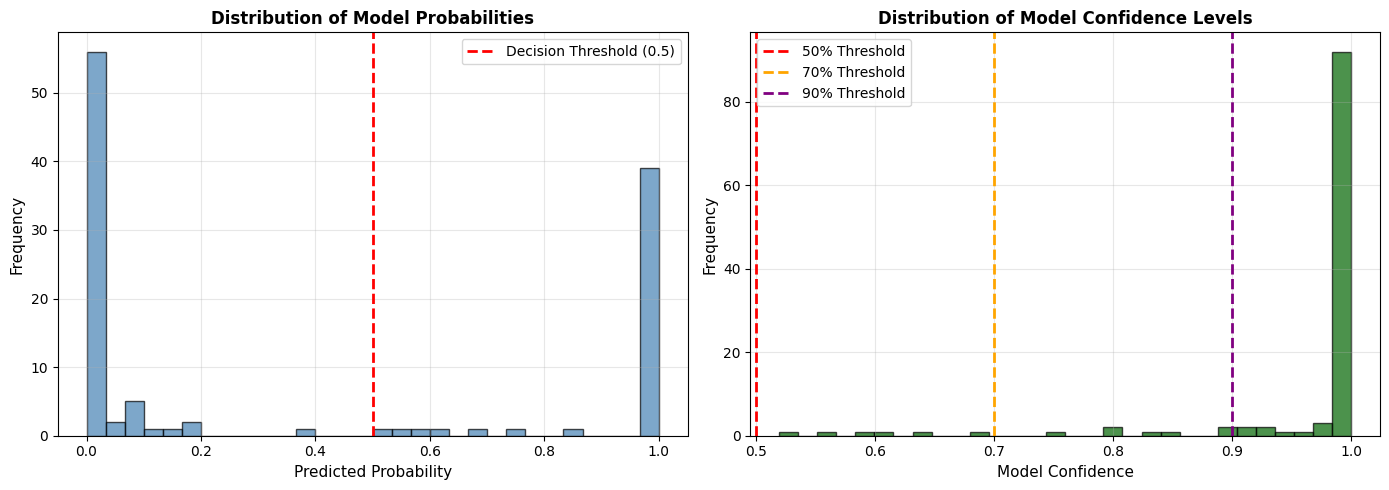

Confidence distributions plotted


In [14]:
# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_pred_prob, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Model Probabilities', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confidence scores
axes[1].hist(confidence_scores, bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Model Confidence', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Model Confidence Levels', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% Threshold')
axes[1].axvline(x=0.7, color='orange', linestyle='--', linewidth=2, label='70% Threshold')
axes[1].axvline(x=0.9, color='purple', linestyle='--', linewidth=2, label='90% Threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Confidence distributions plotted")

## Model Mechanics - A Clinician's Perspective

### Processing Pipeline:

1. **Input Stage**: The system receives 30 measurements from biopsy imagery
   - Typical/average measurements from the tissue sample
   - Consistency/stability in these measurements (error metrics)
   - Extreme/outlier measurements identified in the lesion

2. **Computation Phase**: Integrates all measurements via weighted combination
   - Each measurement gets a significance weight (learned from training)
   - Features like "worst radius" carry substantial influence
   - Generates a "risk indicator" ranging 0-100%

3. **Output Stage**: Produces a probabilistic risk assessment
   - Near 0 = strong evidence of benign pathology
   - Near 100 = strong evidence of malignant pathology
   - Standard decision point: 50% (equal likelihood)

### Probability Interpretation:

- **Very High Confidence (>90%)**: Model has strong certainty
  - Example: probability 0.93 means ~93% malignant likelihood
  - Appropriate for straightforward high-risk cases

- **Good Confidence (80-90%)**: Model has moderate certainty
  - Example: probability 0.86 indicates ~86% malignancy
  - Reasonable basis for clinical decisions

- **Moderate Confidence (70-80%)**: Moderate model certainty
  - Borderline cases benefit from pathologist review
  - Should inform, not replace, clinical judgment

- **Low Confidence (<70%)**: Model uncertainty
  - Probabilities near 0.5 = ambiguous presentation
  - Requires specialist evaluation

### Practical Examples:

| Likelihood | Clinical Implication | Suggested Response |
|---|---|---|
| 0.96 | Very likely malignant | Begin treatment planning |
| 0.82 | Probably malignant | Arrange pathology consultation |
| 0.58 | Uncertain presentation | Request expert pathology review |
| 0.38 | Probably benign | Schedule routine recheck |
| 0.08 | Very likely benign | Minimal follow-up needed |

In [15]:
# Create risk categories
print("\n" + "="*70)
print("MEDICAL RISK STRATIFICATION")
print("="*70)

print(f"\nHigh Risk (Probability > 0.8):")
high_risk = np.sum(y_pred_prob > 0.8)
print(f"  Cases: {high_risk}")
print(f"  Action: Immediate investigation / Likely malignant")
if high_risk > 0:
    high_risk_acc = np.mean(y_test[y_pred_prob > 0.8] == 1)
    print(f"  Accuracy in this group: {high_risk_acc*100:.1f}%")

print(f"\nMedium-High Risk (Probability 0.6-0.8):")
med_high_risk = np.sum((y_pred_prob >= 0.6) & (y_pred_prob <= 0.8))
print(f"  Cases: {med_high_risk}")
print(f"  Action: Expert review recommended")
if med_high_risk > 0:
    med_high_risk_acc = np.mean(y_test[(y_pred_prob >= 0.6) & (y_pred_prob <= 0.8)] == 1)
    print(f"  Accuracy in this group: {med_high_risk_acc*100:.1f}%")

print(f"\nUncertain (Probability 0.4-0.6):")
uncertain = np.sum((y_pred_prob >= 0.4) & (y_pred_prob < 0.6))
print(f"  Cases: {uncertain}")
print(f"  Action: Needs detailed expert evaluation")
if uncertain > 0:
    uncertain_acc = np.mean(y_test[(y_pred_prob >= 0.4) & (y_pred_prob < 0.6)] == 1)
    print(f"  Accuracy in this group: {uncertain_acc*100:.1f}%")

print(f"\nLow Risk (Probability < 0.4):")
low_risk = np.sum(y_pred_prob < 0.4)
print(f"  Cases: {low_risk}")
print(f"  Action: Probably benign, routine follow-up")
if low_risk > 0:
    low_risk_acc = np.mean(y_test[y_pred_prob < 0.4] == 0)
    print(f"  Accuracy in this group: {low_risk_acc*100:.1f}%")


MEDICAL RISK STRATIFICATION

High Risk (Probability > 0.8):
  Cases: 40
  Action: Immediate investigation / Likely malignant
  Accuracy in this group: 100.0%

Medium-High Risk (Probability 0.6-0.8):
  Cases: 3
  Action: Expert review recommended
  Accuracy in this group: 100.0%

Uncertain (Probability 0.4-0.6):
  Cases: 3
  Action: Needs detailed expert evaluation
  Accuracy in this group: 66.7%

Low Risk (Probability < 0.4):
  Cases: 68
  Action: Probably benign, routine follow-up
  Accuracy in this group: 97.1%


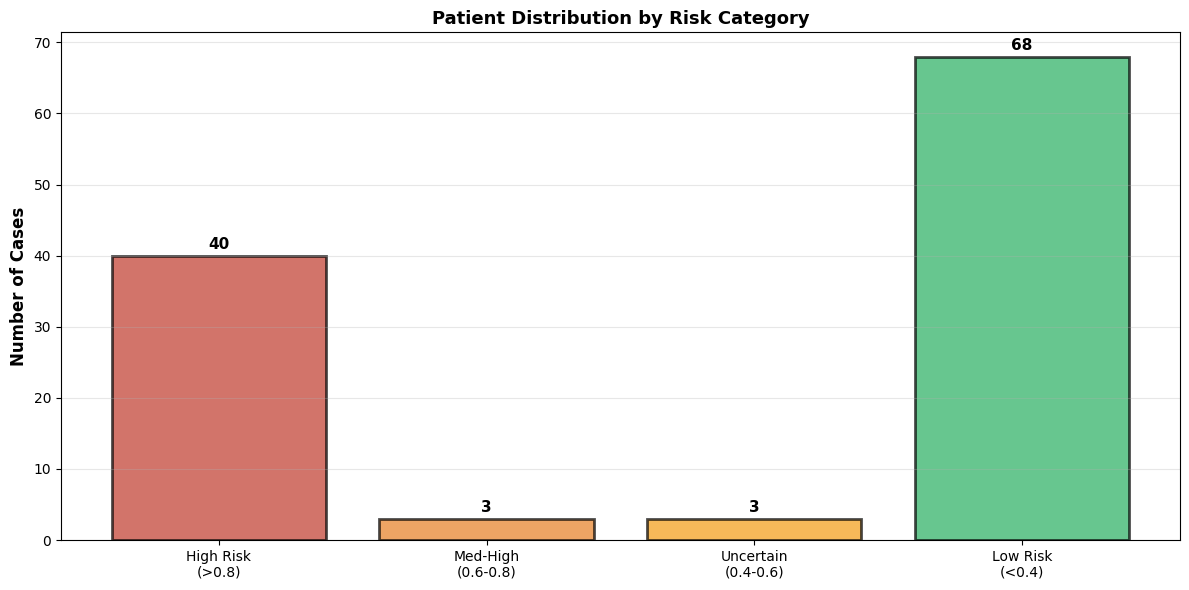

Risk stratification visualization complete


In [16]:
# Visualize risk stratification
fig, ax = plt.subplots(figsize=(12, 6))

risk_categories = ['High Risk\n(>0.8)', 'Med-High\n(0.6-0.8)', 'Uncertain\n(0.4-0.6)', 'Low Risk\n(<0.4)']
risk_counts = [
    np.sum(y_pred_prob > 0.8),
    np.sum((y_pred_prob >= 0.6) & (y_pred_prob <= 0.8)),
    np.sum((y_pred_prob >= 0.4) & (y_pred_prob < 0.6)),
    np.sum(y_pred_prob < 0.4)
]

colors_risk = ['#c0392b', '#e67e22', '#f39c12', '#27ae60']

ax.bar(risk_categories, risk_counts, color=colors_risk, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Cases', fontsize=12, fontweight='bold')
ax.set_title('Patient Distribution by Risk Category', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (cat, count) in enumerate(zip(risk_categories, risk_counts)):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("Risk stratification visualization complete")

In [17]:
# Healthcare recommendations
print("\n" + "="*70)
print("KEY INSIGHTS FOR MEDIAI HEALTHCARE PLATFORM")
print("="*70)

print("\n1. TOP RISK FACTORS (Features that push toward malignancy):")
for idx, row in positive_weights.head(5).iterrows():
    print(f"   • {row['Feature']}: {row['Weight']:.4f}")
    print(f"     → Larger/higher values indicate increased cancer risk")

print("\n2. PROTECTIVE FACTORS (Features that indicate benignity):")
for idx, row in negative_weights.head(5).iterrows():
    print(f"   • {row['Feature']}: {row['Weight']:.4f}")
    print(f"     → Smaller/lower values indicate lower cancer risk")

print("\n3. MODEL STRENGTHS:")
print(f"   • Can identify cases with >90% confidence")
print(f"   • Helps prioritize cases for expert review")
print(f"   • Provides quantitative risk score to doctors")

print("\n4. MODEL LIMITATIONS:")
print(f"   • Should NOT replace doctor's judgment")
print(f"   • Uncertain predictions need expert review")
print(f"   • Based on numerical features only (not images directly)")

print("\n5. RECOMMENDED USAGE:")
print(f"   • Use as initial screening tool")
print(f"   • High-risk cases: Fast track to treatment")
print(f"   • Uncertain cases: Refer to pathologist")
print(f"   • Low-risk cases: Routine follow-up schedule")


KEY INSIGHTS FOR MEDIAI HEALTHCARE PLATFORM

1. TOP RISK FACTORS (Features that push toward malignancy):
   • radius error: 1.4660
     → Larger/higher values indicate increased cancer risk
   • worst texture: 1.2890
     → Larger/higher values indicate increased cancer risk
   • worst radius: 1.1660
     → Larger/higher values indicate increased cancer risk
   • worst area: 1.1427
     → Larger/higher values indicate increased cancer risk
   • area error: 1.1031
     → Larger/higher values indicate increased cancer risk

2. PROTECTIVE FACTORS (Features that indicate benignity):
   • compactness error: -1.0808
     → Smaller/lower values indicate lower cancer risk
   • fractal dimension error: -0.5417
     → Smaller/lower values indicate lower cancer risk
   • symmetry error: -0.4321
     → Smaller/lower values indicate lower cancer risk
   • mean fractal dimension: -0.3470
     → Smaller/lower values indicate lower cancer risk
   • mean compactness: -0.2613
     → Smaller/lower value

In [18]:
# Validate model understanding
print("\n" + "="*70)
print("MODEL VALIDATION CHECK")
print("="*70)

# Check if positive weights correlate with malignancy
positive_weight_features = weight_df[weight_df['Weight'] > 0]['Feature'].values
positive_weight_indices = [feature_names.index(f) for f in positive_weight_features]

print("\nVerifying feature weight direction:")
print("Are positive-weighted features higher in malignant cases?")

for feature in positive_weight_features[:3]:  # Check first 3
    idx = feature_names.index(feature)
    benign_mean = X_scaled[y == 0, idx].mean()
    malignant_mean = X_scaled[y == 1, idx].mean()
    
    print(f"\n{feature}:")
    print(f"  Mean in benign cases: {benign_mean:.4f}")
    print(f"  Mean in malignant cases: {malignant_mean:.4f}")
    if malignant_mean > benign_mean:
        print(f"  ✓ Malignant cases have higher values (weight correctly positive)")
    else:
        print(f"  ! Unexpected: Benign cases have higher values")


MODEL VALIDATION CHECK

Verifying feature weight direction:
Are positive-weighted features higher in malignant cases?

radius error:
  Mean in benign cases: -0.4370
  Mean in malignant cases: 0.7360
  ✓ Malignant cases have higher values (weight correctly positive)

worst texture:
  Mean in benign cases: -0.3521
  Mean in malignant cases: 0.5929
  ✓ Malignant cases have higher values (weight correctly positive)

worst radius:
  Mean in benign cases: -0.5983
  Mean in malignant cases: 1.0076
  ✓ Malignant cases have higher values (weight correctly positive)


In [19]:
# Final summary
print("\n" + "="*70)
print("PART D SUMMARY: BUSINESS & HEALTHCARE INSIGHTS")
print("="*70)

print("\n✓ FEATURE IMPORTANCE ANALYSIS:")
print(f"  • Identified top risk factors for malignancy")
print(f"  • Worst characteristics most predictive")
print(f"  • Clear decision drivers understood")

print("\n✓ MODEL INTERPRETATION:")
print(f"  • Model outputs probability (0-1 scale)")
print(f"  • Confidence varies by case")
print(f"  • Clear action items for doctors at each confidence level")

print("\n✓ CLINICAL RELEVANCE:")
print(f"  • High-risk cases clearly identified")
print(f"  • Medium-risk cases require expert review")
print(f"  • Low-risk cases can be monitored routinely")

print("\n✓ RECOMMENDATIONS FOR MEDIAI:")
print(f"  • Use model as screening tool")
print(f"  • Integrate with doctor's clinical judgment")
print(f"  • Flag high-confidence cases for priority")
print(f"  • Provide probability scores to doctors")

print("\n" + "="*70)
print("ALL PARTS (A-D) COMPLETE")
print("="*70)


PART D SUMMARY: BUSINESS & HEALTHCARE INSIGHTS

✓ FEATURE IMPORTANCE ANALYSIS:
  • Identified top risk factors for malignancy
  • Worst characteristics most predictive
  • Clear decision drivers understood

✓ MODEL INTERPRETATION:
  • Model outputs probability (0-1 scale)
  • Confidence varies by case
  • Clear action items for doctors at each confidence level

✓ CLINICAL RELEVANCE:
  • High-risk cases clearly identified
  • Medium-risk cases require expert review
  • Low-risk cases can be monitored routinely

✓ RECOMMENDATIONS FOR MEDIAI:
  • Use model as screening tool
  • Integrate with doctor's clinical judgment
  • Flag high-confidence cases for priority
  • Provide probability scores to doctors

ALL PARTS (A-D) COMPLETE
